In [133]:
%matplotlib nbagg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import chainer
import chainer.functions as F
import chainer.links as L
import chainer.initializers as I

from ipywidgets import widgets
from ipywidgets.widgets import *
from IPython.display import display

<IPython.core.display.Javascript object>


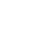

In [126]:
points = np.array([[-1, -1, -1],
                      [1, -1, -1 ],
                      [1, 1, -1],
                      [-1, 1, -1],
                      [-1, -1, 1],
                      [1, -1, 1 ],
                      [1, 1, 1],
                      [-1, 1, 1]])

figsize = 0.5
fig = plt.figure(figsize=(figsize,figsize))
trimwidth = int(figsize * 12)
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111, projection='3d')
r = [-1,1]
X, Y = np.meshgrid(r, r)
ax.plot_surface(X,Y,1)
ax.plot_surface(X,Y,-1)
ax.plot_surface(X,-1,Y)
ax.plot_surface(X,1,Y)
ax.plot_surface(1,X,Y)
ax.plot_surface(-1,X,Y)
plt.axis('off')
def get_yaw(i):
    return i * np.pi / 2 / 5
def get_pitch(i): return i * np.pi / 4 / 5
yaw_angles = get_yaw(np.arange(5))
pitch_angles = get_pitch(np.arange(5))
yaw_mat, pitch_mat = np.meshgrid(yaw_angles, pitch_angles)
images = []
for pitch in pitch_angles:
    for yaw in yaw_angles:
        ax.view_init(pitch * 180 / np.pi, yaw * 180 / np.pi)
        canvas.draw()
        rawimage = np.fromstring(canvas.tostring_rgb(), dtype='uint8')
        image = rawimage.reshape((int(np.sqrt(len(rawimage) // 3)), -1, 3))
        cropimage = image[trimwidth:-trimwidth, trimwidth:-trimwidth, :]
        rawcropimage = np.array(cropimage.flat)
        images.append(rawcropimage)

In [3]:
print(np.array(images).max())

255


In [127]:
def plotimg(yaw,pitch):
    print(images[yaw + pitch * len(yaw_angles)].shape)
    image = images[yaw + pitch * len(yaw_angles)]
    img = image.reshape((int(np.sqrt(len(image) // 3)), -1, 3))
    print(img.shape)
    plt.imshow(img)
    k = np.arange(50)

interact(plotimg, yaw=(0,len(yaw_angles)-1,1), pitch=(0,len(pitch_angles)-1,1));

(1728,)
(24, 24, 3)


In [5]:
class Regressor(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(Regressor, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        return h2

In [6]:
class Regressor2(chainer.Chain):
    def __init__(self, outputs=1, n_units=128, output=F.sigmoid):
        self.output = output
        super(Regressor2, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.output(self.l3(h2)) * 255

In [194]:
class Regressor3(chainer.Chain):
    def __init__(self, outputs=1, n_units=128, outputfun=F.sigmoid):
        self.outputfun = outputfun
        super(Regressor3, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, n_units),
            l4 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        return self.outputfun(self.l4(h3)) * 255

In [7]:
class CNNRegressor2(chainer.Chain):
    def __init__(self, outputs=1, n_units=128):
        super(CNNRegressor2, self).__init__(
            conv1 = L.Convolution2D(None, n_units, ksize=3),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = self.conv1(x)
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [195]:
def run_train(trainx, trainy, epoch=10000, report_period=100, report_period_seconds=0, regularize=0.0001,
              model=None, optimizer=None):
    from time import clock
    start = clock()
    last_report = start

    if model == None:
        model = Regressor3(trainy.shape[1], 256)
        model.zerograds()

    if optimizer == None:
        optimizer = chainer.optimizers.Adam()
        optimizer.setup(model)
        optimizer.add_hook(chainer.optimizer.WeightDecay(regularize))
    loss_hist = []

    try:
        for i in range(epoch):
            loss = F.mean_squared_error(model(trainx), trainy)
            loss_hist.append(loss.data)
            if i % report_period == 0:
                if last_report + report_period_seconds < clock():
                    ups = i / (clock() - start)
                    eta = (epoch - i) / ups if ups != 0 else 0
                    etas = '%d:%05.2f' % (eta // 60, eta % 60) if 60 < eta else '%.2f' % eta
                    print(i, 'loss', loss.data, ', ups: %.2f' % ups, ', eta: ' + etas)
                    last_report = clock()
            #optimizer.weight_decay(0.005)
            optimizer.update(lambda x,y: F.mean_squared_error(model(x), y), trainx, trainy)
    except KeyboardInterrupt:
        print('Interrupted')

    return model, loss_hist, optimizer

In [196]:
use_flat = True
if use_flat:
    x = y = range(int(np.sqrt(len(images[0]) // 3)))
    print(len(x))
    A, P, X, Y = np.meshgrid(yaw_angles, pitch_angles, x, y)
    print(X.shape, Y.shape, A.shape[0] * A.shape[1] * A.shape[2])
    APXY = np.vstack([A.flat, P.flat, np.array(X.flat), np.array(Y.flat)]).astype(np.float32).T
    trainx = APXY
    print(APXY.shape, 'image: ', images[0].shape)
    imageXY = np.zeros((trainx.shape[0],3))
    i = 0
    for image in images:
        imageXY[i:(i+image.shape[0]//3),:] = image.reshape((-1,3))
        i += image.shape[0]//3
    trainy = np.array(imageXY, dtype=np.float32)
else:
    trainx = np.vstack([yaw_mat.flat, pitch_mat.flat]).astype(np.float32).T
    trainy = np.array(images, dtype=np.float32)
print(trainx.shape, trainy.shape)


24
(5, 5, 24, 24) (5, 5, 24, 24) 600
(14400, 4) image:  (1728,)
(14400, 4) (14400, 3)


In [197]:
model, loss_hist, optimizer = run_train(trainx, trainy, epoch=100, report_period=10, report_period_seconds=5, regularize=0.00001)

10 loss 9511.3125 , ups: 1.92 , eta: 46.77
20 loss 6567.72021484375 , ups: 1.92 , eta: 41.71
30 loss 5908.9619140625 , ups: 1.86 , eta: 37.68
40 loss 5506.15185546875 , ups: 1.88 , eta: 31.87
50 loss 5244.525390625 , ups: 1.89 , eta: 26.46
60 loss 5040.80517578125 , ups: 1.88 , eta: 21.26
70 loss 4935.54833984375 , ups: 1.89 , eta: 15.84
80 loss 4764.84716796875 , ups: 1.90 , eta: 10.50
90 loss 4681.505859375 , ups: 1.91 , eta: 5.22


In [235]:
model, loss_hist, optimizer = run_train(trainx, trainy, epoch=200, report_period=10, report_period_seconds=5, regularize=0.00001, model=model, optimizer=optimizer)

10 loss 574.9312744140625 , ups: 1.00 , eta: 3:09.24
20 loss 461.9343566894531 , ups: 1.01 , eta: 2:57.46
30 loss 353.9702453613281 , ups: 1.02 , eta: 2:46.49
40 loss 319.63922119140625 , ups: 1.02 , eta: 2:36.68
50 loss 334.9882507324219 , ups: 1.02 , eta: 2:27.64
60 loss 476.80902099609375 , ups: 1.01 , eta: 2:17.93
70 loss 687.711669921875 , ups: 1.01 , eta: 2:08.41
80 loss 425.7923583984375 , ups: 1.01 , eta: 1:58.45
90 loss 310.3209228515625 , ups: 1.01 , eta: 1:48.51
100 loss 305.5892028808594 , ups: 1.01 , eta: 1:38.72
110 loss 339.3851318359375 , ups: 1.01 , eta: 1:28.79
120 loss 436.0895690917969 , ups: 1.01 , eta: 1:19.02
130 loss 594.929931640625 , ups: 1.01 , eta: 1:09.23
140 loss 555.6858520507812 , ups: 1.01 , eta: 59.39
150 loss 378.8504943847656 , ups: 1.01 , eta: 49.54
160 loss 289.62274169921875 , ups: 1.01 , eta: 39.69
170 loss 293.1993408203125 , ups: 1.01 , eta: 29.80
180 loss 523.8192749023438 , ups: 1.01 , eta: 19.88
190 loss 622.4324340820312 , ups: 1.00 , eta: 

In [231]:
chainer.serializers.save_npz("result/image3d2_25px.model", model)

<IPython.core.display.Javascript object>


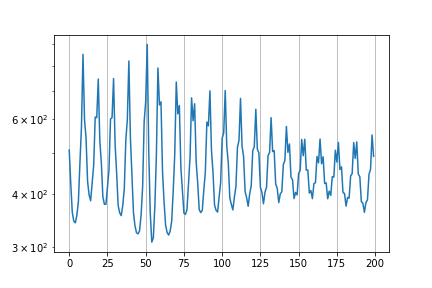

In [233]:
plt.semilogy(loss_hist)
plt.grid()

<IPython.core.display.Javascript object>


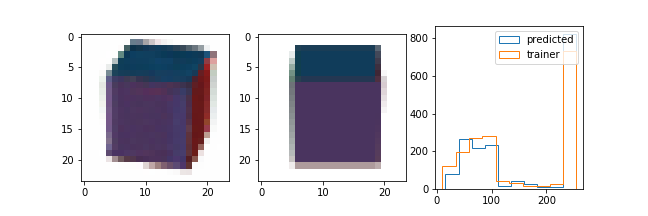

In [136]:
def plotimg(yaw,pitch,image_only=False,ax=None):
    predicted = model(np.array([get_yaw(yaw), get_pitch(pitch)], dtype=np.float32)[np.newaxis]).data
    print(predicted.shape, predicted.min(), predicted.max())
    xs = int(np.sqrt(predicted.shape[1] // 3))
    img = predicted.reshape((xs, -1, 3))
    if image_only:
        return plt.imshow(img / 255)
    else:
        if ax == None:
            fig, ax = plt.subplots(1, 3, figsize=(9,3))
        for a in ax: a.clear()
        ax[0].imshow(img / 255)
        iyaw = int(yaw)
        ipitch = int(pitch)
        if 0 <= iyaw and iyaw < len(yaw_angles) and 0 <= ipitch and ipitch < len(pitch_angles):
            image = images[iyaw + ipitch * len(yaw_angles)]
            img2 = image.reshape((int(np.sqrt(len(image) // 3)), -1, 3))
            ax[1].imshow(img2)
            ax[2].hist(img2.flat, histtype='step')
        ax[2].hist(predicted.flat, histtype='step')
        ax[2].legend(['predicted', 'trainer'])

interactive = False
if interactive:
    interact(lambda yaw,pitch: plotimg(yaw,pitch), yaw=(-10,len(yaw_angles)+10,1), pitch=(-10,len(pitch_angles)+10,1));
else:
    import matplotlib.animation as animation
    fig, ax = plt.subplots(1, 3, figsize=(9,3))
    supersample = 5

    def img_init():
        pass

    def img_animate(i):
        yaw = (i / supersample) % len(yaw_angles)
        pitch = np.floor((i / supersample) / len(yaw_angles)) / supersample
        print(pitch, yaw)
        plotimg(yaw, pitch, ax=ax)
        #xx = np.arange(0, 10, 0.01)
        #im = plt.plot(xx, pitch * np.sin(yaw * xx), "r")
        #ims.append(im)
    #print(len(ims))
    #ani = animation.ArtistAnimation(fig, ims)
    ani = animation.FuncAnimation(fig, img_animate, init_func=img_init,
                               frames=len(pitch_angles)*len(yaw_angles)*(supersample**2), interval=100, blit=True)
    #HTML(ani.to_html5_video())
    #plt.show()

<IPython.core.display.Javascript object>


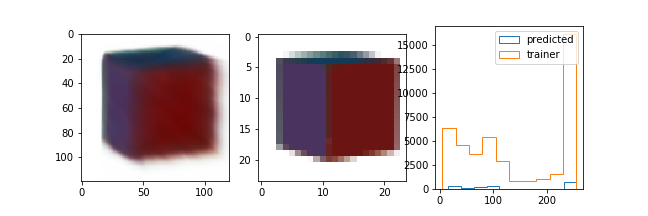

In [236]:
def plotimg(yaw,pitch,image_only=False,ax=None):
    def upsample(x): return np.linspace(min(x),max(x),len(x)*5)
    X, Y = np.meshgrid(upsample(x), upsample(y))
    print(X.shape, len(x), y)
    XYA = np.vstack([np.ones(X.shape[0] * X.shape[1]) * get_yaw(yaw),
                     np.ones(X.shape[0] * X.shape[1]) * get_pitch(pitch),
                     np.array(X.flat), np.array(Y.flat)]).astype(np.float32).T
    predicted = model(XYA).data
    xs = X.shape[0]
    print(predicted.shape, xs, predicted.shape[0] // (3 * xs))
    img = predicted.reshape((xs, -1, 3)).transpose((1,0,2))
    #print(img.shape)
    if image_only:
        return plt.imshow(img / 255)
    else:
        if ax == None:
            fig, ax = plt.subplots(1, 3, figsize=(9,3))
        for a in ax: a.clear()
        ax[0].imshow(img / 255)
        iyaw = int(yaw)
        ipitch = int(pitch)
        if 0 <= iyaw and iyaw < len(yaw_angles) and 0 <= ipitch and ipitch < len(pitch_angles):
            image = images[iyaw + ipitch * len(yaw_angles)]
            img2 = image.reshape((int(np.sqrt(len(image) // 3)), -1, 3))
            ax[1].imshow(img2)
            ax[2].hist(img2.flat, histtype='step')
        ax[2].hist(predicted.flat, histtype='step')
        ax[2].legend(['predicted', 'trainer'])

interactive = False
if interactive:
    interact(lambda yaw,pitch: plotimg(yaw,pitch), yaw=(0,len(yaw_angles)-1,0.5), pitch=(0,len(pitch_angles)-1,0.5));
else:
    import matplotlib.animation as animation
    fig, ax = plt.subplots(1, 3, figsize=(9,3))
    supersample = 3

    def img_init():
        pass

    def img_animate(i):
        yaw = (i / supersample) % len(yaw_angles)
        pitch = np.floor((i / supersample) / len(yaw_angles)) / supersample
        print(pitch, yaw)
        plotimg(yaw, pitch, ax=ax)
        #xx = np.arange(0, 10, 0.01)
        #im = plt.plot(xx, pitch * np.sin(yaw * xx), "r")
        #ims.append(im)
    #print(len(ims))
    #ani = animation.ArtistAnimation(fig, ims)
    ani = animation.FuncAnimation(fig, img_animate, init_func=img_init,
                               frames=len(pitch_angles)*len(yaw_angles)*(supersample**2), interval=100, blit=True)
    #HTML(ani.to_html5_video())
    #plt.show()